## Image recognition using PreTrained Models

#### Training
Testing some Pretrained model to use in the classification task.

In [ ]:
import cv2
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

(x_train, y_train), (x_valid, y_valid) = tf.keras.datasets.cifar10.load_data()
#x_train, x_valid = x_train / 255.0, x_valid / 255.0

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

170498071/170498071 [==============================] - 13s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


#Common functions

In [ ]:
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    return x

In [ ]:
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    net_feature_extractor = feature_extractor(resize)
    classification_output = classifier(net_feature_extractor)

    return classification_output

In [ ]:
from keras.optimizers import Adam, SGD
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
  model.compile(optimizer=SGD(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

  return model

In [ ]:
from keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

#RESNET

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [ ]:
x_train_res = preprocess_image_input(x_train)
x_valid_res = preprocess_image_input(x_valid)

In [ ]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

In [ ]:
model_res = define_compile_model()

model_res.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

In [ ]:
EPOCHS = 3
history_res = model_res.fit(x_train_res, y_train, epochs=EPOCHS, callbacks=callbacks, validation_data = (x_valid_res, y_valid), batch_size=8)

Epoch 1/3
6250/6250 [==============================] - ETA: 0s - loss: 0.4345 - accuracy: 0.8534
Epoch 1: val_accuracy improved from -inf to 0.92760, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6250/6250 [==============================] - 690s 106ms/step - loss: 0.4345 - accuracy: 0.8534 - val_loss: 0.2154 - val_accuracy: 0.9276 - lr: 0.0100
Epoch 2/3
6250/6250 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9395
Epoch 2: val_accuracy improved from 0.92760 to 0.94010, saving model to model.hdf5
6250/6250 [==============================] - 666s 106ms/step - loss: 0.1769 - accuracy: 0.9395 - val_loss: 0.1794 - val_accuracy: 0.9401 - lr: 0.0100
Epoch 3/3
6250/6250 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9650
Epoch 3: val_accuracy did not improve from 0.94010
6250/6250 [==============================] - 668s 107ms/step - loss: 0.1024 - accuracy: 0.9650 - val_loss: 0.2455 - val_accuracy: 0.9271 - lr: 0.0100


In [ ]:
import numpy as np

# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for idx in range(len(y_valid)):
  # Generate prediction
  img = cv2.resize(x_valid_res[idx], dsize=(32, 32))
  img = np.expand_dims(img, axis=0)
  predictions = model_res.predict(img)
  # Save prediction
  pred_category = np.argmax(predictions)
  pred_score = np.max(predictions)
  y_true.append(y_valid[idx])
  y_pred.append(pred_category)
  print(y_valid[idx], pred_category)

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 21ms/step
[6] 6
1/1 [==============================] - 0s 21ms/step
[9] 9
1/1 [==============================] - 0s 21ms/step
[8] 8
1/1 [==============================] - 0s 21ms/step
[8] 8
1/1 [==============================] - 0s 22ms/step
[6] 6
1/1 [==============================] - 0s 22ms/step
[7] 7
1/1 [==============================] - 0s 22ms/step
[4] 4
1/1 [==============================] - 0s 22ms/step
[7] 7
1/1 [==============================] - 0s 21ms/step
[2] 2
1/1 [==============================] - 0s 21ms/step
[3] 3
1/1 [==============================] - 0s 23ms/step
[8] 8
1/1 [==============================] - 0s 23ms/step
[0] 0
1/1 [==============================] - 0s 21ms/step
[9] 9
1/1 [==============================] - 0s 21ms/step
[0] 0
1/1 [==============================] - 0s 22ms/step
[7] 7
1/1 [==============================] - 0s 21ms/step
[8] 8
1/1 [======

<ipython-input-28-99500a24dd45>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


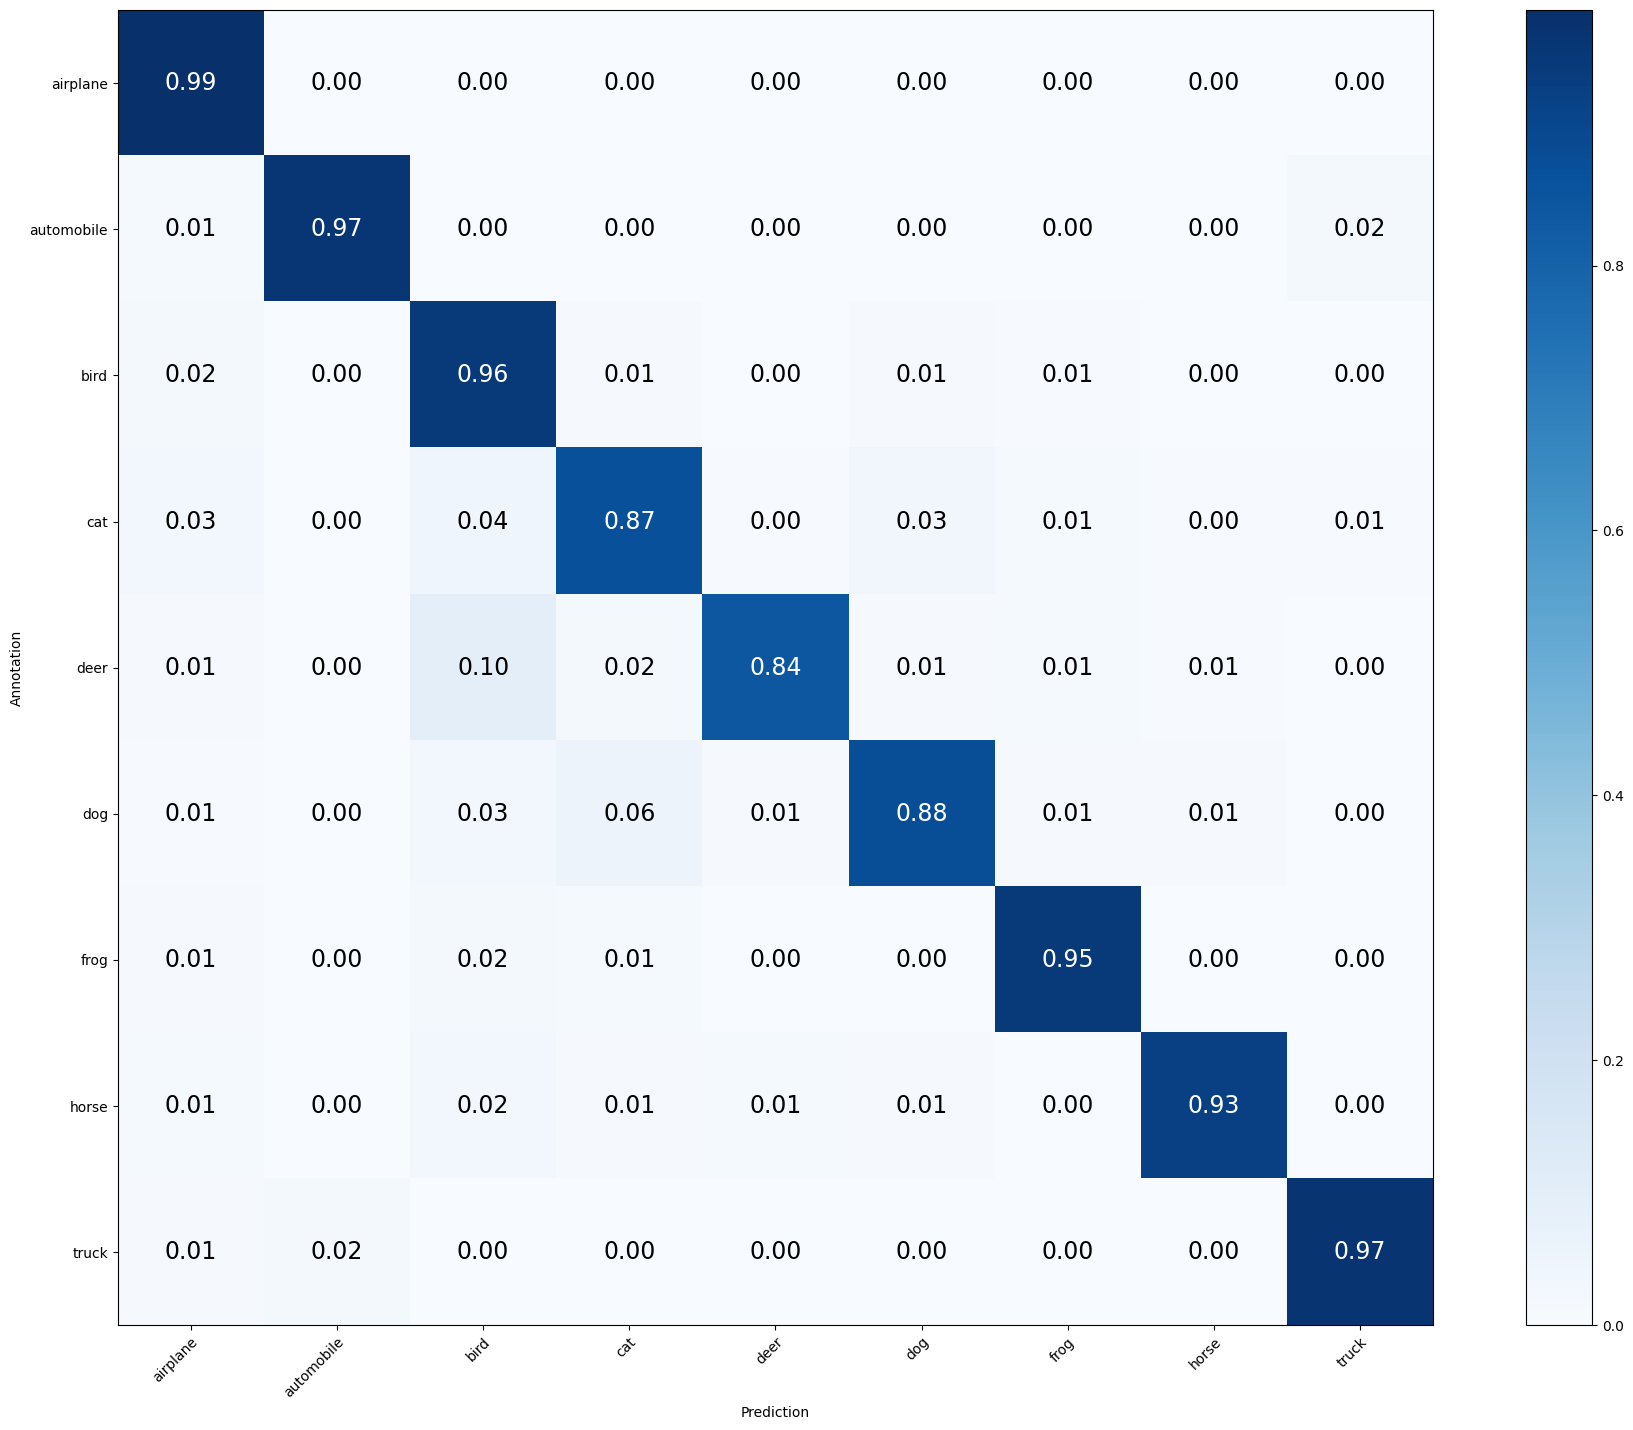

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)
  # Compute the confusion matrix
categories = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 9: 'ship', 9: 'truck'}
cm = confusion_matrix(y_true, y_pred, labels=list(categories.keys()))
draw_confusion_matrix(cm, categories)

In [ ]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 92.908%
Mean Recall: 92.923%
Mean Precision: 93.234%
> airplane: Recall: 99.286% Precision: 90.018% Specificity: 98.643% Dice: 94.426%
> automobile: Recall: 96.774% Precision: 97.760% Specificity: 99.723% Dice: 97.264%
> bird: Recall: 95.596% Precision: 81.694% Specificity: 97.305% Dice: 88.100%
> cat: Recall: 86.957% Precision: 89.212% Specificity: 98.692% Dice: 88.070%
> deer: Recall: 84.469% Precision: 96.674% Specificity: 99.635% Dice: 90.160%
> dog: Recall: 87.800% Precision: 92.910% Specificity: 99.156% Dice: 90.283%
> frog: Recall: 95.482% Precision: 95.482% Specificity: 99.434% Dice: 95.482%
> horse: Recall: 92.986% Precision: 98.201% Specificity: 99.786% Dice: 95.522%
> truck: Recall: 96.960% Precision: 97.157% Specificity: 99.648% Dice: 97.059%


#MOBILENET V2

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.mobilenet_v2.preprocess_input(input_images)
  return output_ims

In [ ]:
x_train_mobile = preprocess_image_input(x_train)
x_valid_mobile = preprocess_image_input(x_valid)

In [ ]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

In [ ]:
model_mobile = define_compile_model()

model_mobile.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0      

In [ ]:
EPOCHS = 3
history_mobile = model_mobile.fit(x_train_mobile, y_train, epochs=EPOCHS, callbacks=callbacks, validation_data = (x_valid_mobile, y_valid), batch_size=8)

Epoch 1/3
6249/6250 [============================>.] - ETA: 0s - loss: 0.6033 - accuracy: 0.7971
Epoch 1: val_accuracy did not improve from 0.94010
6250/6250 [==============================] - 260s 39ms/step - loss: 0.6033 - accuracy: 0.7971 - val_loss: 0.4580 - val_accuracy: 0.8487 - lr: 0.0100
Epoch 2/3
6250/6250 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.8912
Epoch 2: val_accuracy did not improve from 0.94010
6250/6250 [==============================] - 234s 37ms/step - loss: 0.3197 - accuracy: 0.8912 - val_loss: 0.3004 - val_accuracy: 0.8982 - lr: 0.0100
Epoch 3/3
6250/6250 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9237
Epoch 3: val_accuracy did not improve from 0.94010
6250/6250 [==============================] - 247s 40ms/step - loss: 0.2269 - accuracy: 0.9237 - val_loss: 0.2452 - val_accuracy: 0.9193 - lr: 0.0100


In [ ]:
import numpy as np

# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for idx in range(len(y_valid)):
  # Generate prediction
  img = cv2.resize(x_valid_mobile[idx], dsize=(32, 32))
  img = np.expand_dims(img, axis=0)
  predictions = model_mobile.predict(img)
  # Save prediction
  pred_category = np.argmax(predictions)
  pred_score = np.max(predictions)
  y_true.append(y_valid[idx])
  y_pred.append(pred_category)
  print(y_valid[idx], pred_category)

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 22ms/step
[6] 6
1/1 [==============================] - 0s 21ms/step
[9] 9
1/1 [==============================] - 0s 25ms/step
[8] 8
1/1 [==============================] - 0s 20ms/step
[8] 8
1/1 [==============================] - 0s 23ms/step
[6] 6
1/1 [==============================] - 0s 24ms/step
[7] 7
1/1 [==============================] - 0s 32ms/step
[4] 4
1/1 [==============================] - 0s 42ms/step
[7] 7
1/1 [==============================] - 0s 31ms/step
[2] 2
1/1 [==============================] - 0s 34ms/step
[3] 5
1/1 [==============================] - 0s 59ms/step
[8] 8
1/1 [==============================] - 0s 33ms/step
[0] 0
1/1 [==============================] - 0s 62ms/step
[9] 9
1/1 [==============================] - 0s 36ms/step
[0] 0
1/1 [==============================] - 0s 31ms/step
[7] 7
1/1 [==============================] - 0s 35ms/step
[8] 8
1/1 [======

<ipython-input-31-99500a24dd45>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


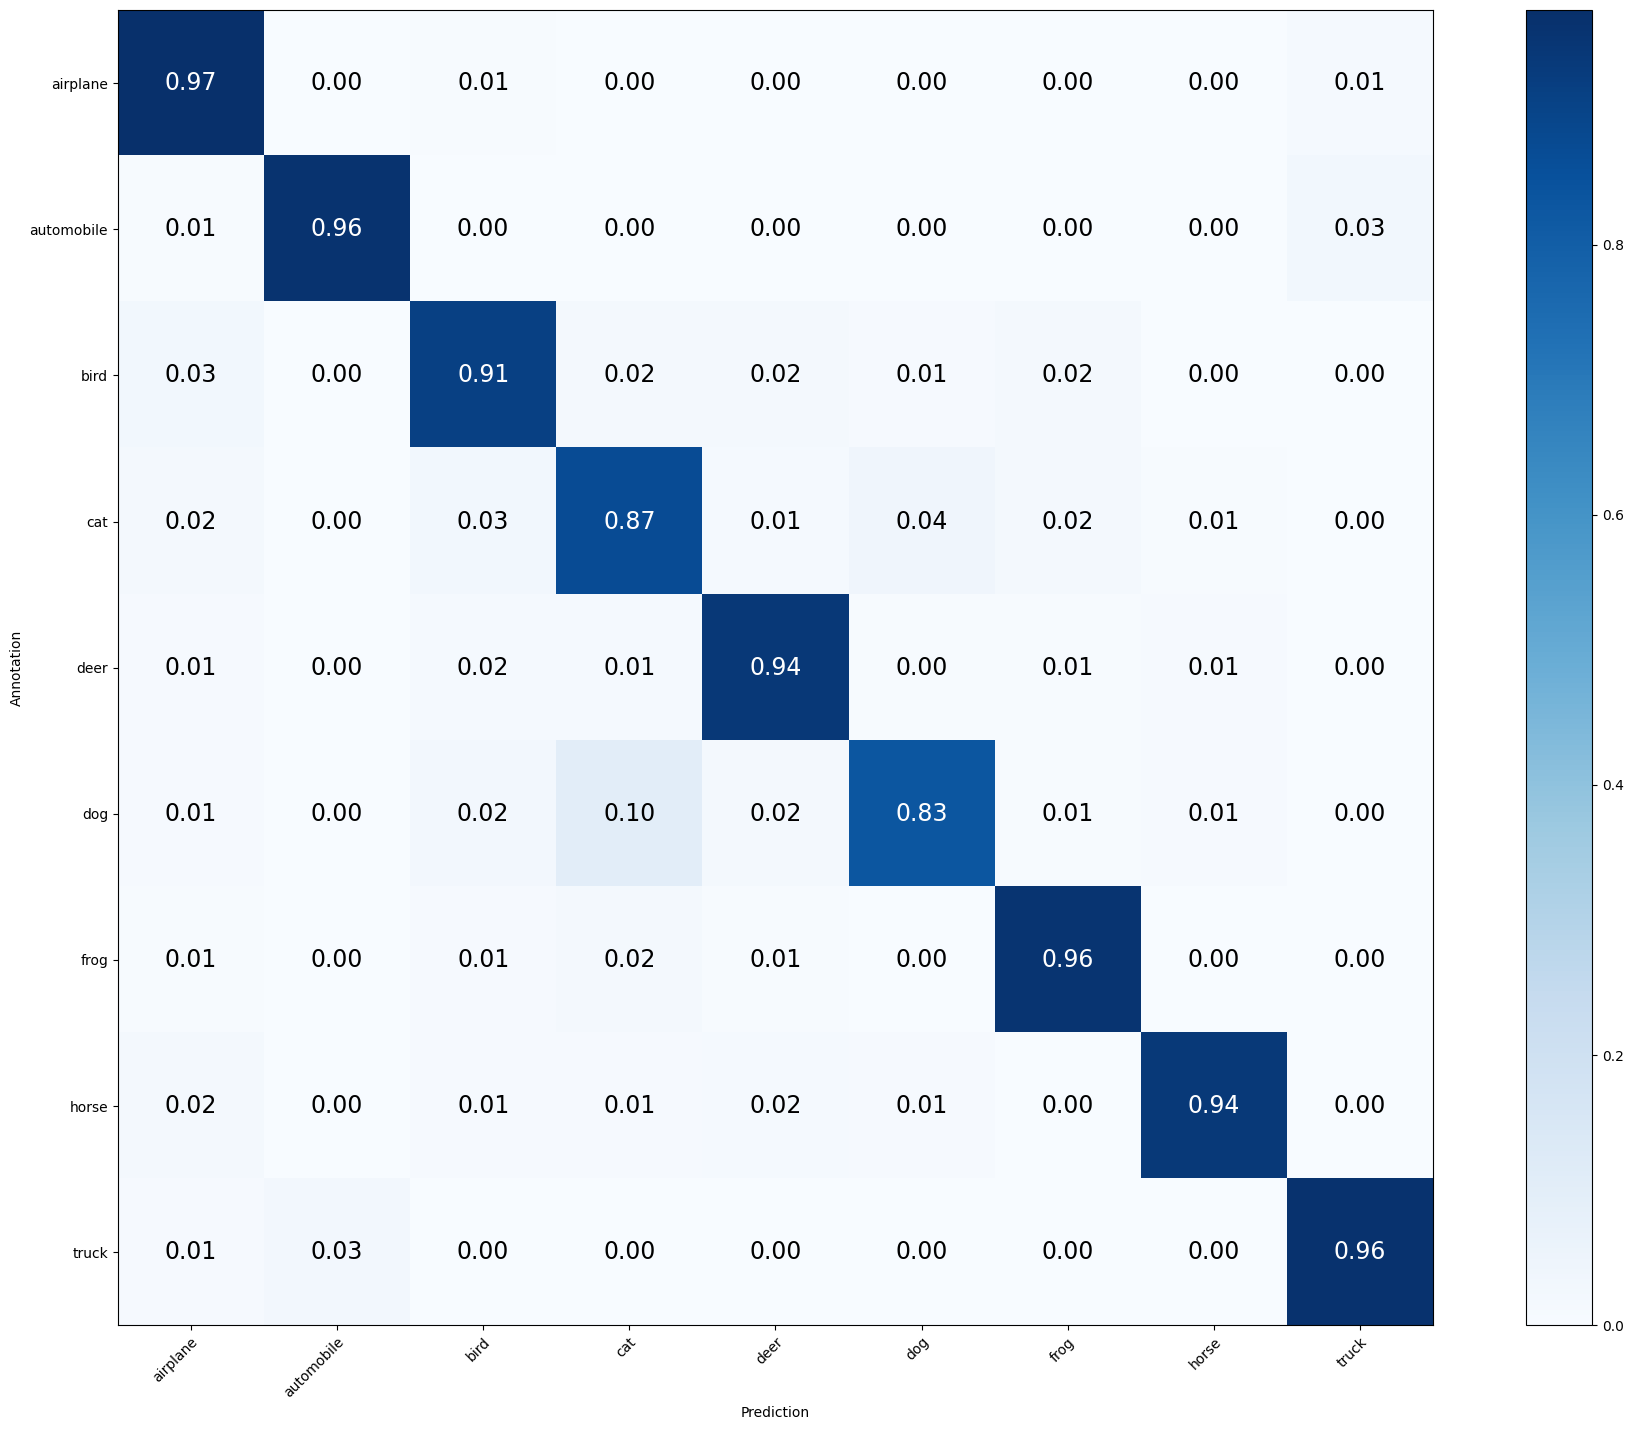

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)
  # Compute the confusion matrix
categories = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 9: 'ship', 9: 'truck'}
cm = confusion_matrix(y_true, y_pred, labels=list(categories.keys()))
draw_confusion_matrix(cm, categories)

In [ ]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 92.728%
Mean Recall: 92.746%
Mean Precision: 92.781%
> airplane: Recall: 97.371% Precision: 89.903% Specificity: 98.684% Dice: 93.488%
> automobile: Recall: 96.158% Precision: 96.942% Specificity: 99.619% Dice: 96.548%
> bird: Recall: 91.194% Precision: 90.735% Specificity: 98.831% Dice: 90.964%
> cat: Recall: 86.899% Precision: 83.976% Specificity: 97.944% Dice: 85.412%
> deer: Recall: 93.988% Precision: 93.148% Specificity: 99.122% Dice: 93.566%
> dog: Recall: 83.165% Precision: 93.115% Specificity: 99.224% Dice: 87.859%
> frog: Recall: 95.661% Precision: 95.085% Specificity: 99.377% Dice: 95.372%
> horse: Recall: 93.869% Precision: 96.788% Specificity: 99.606% Dice: 95.306%
> truck: Recall: 96.410% Precision: 95.335% Specificity: 99.416% Dice: 95.869%


#DENSENET

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.densenet.preprocess_input(input_images)
  return output_ims

In [ ]:
x_train_dense = preprocess_image_input(x_train)
x_valid_dense = preprocess_image_input(x_valid)

In [ ]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

In [ ]:
model_dense = define_compile_model()

model_dense.summary()

74836368/74836368 [==============================] - 4s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_2  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 1920)              0         
                                                            

In [ ]:
EPOCHS = 3
history_dense = model_dense.fit(x_train_dense, y_train, epochs=EPOCHS, callbacks=callbacks, validation_data = (x_valid_dense, y_valid), batch_size=8)

Epoch 1/3
6250/6250 [==============================] - ETA: 0s - loss: 0.4197 - accuracy: 0.8592
Epoch 1: val_accuracy did not improve from 0.94010
6250/6250 [==============================] - 1143s 171ms/step - loss: 0.4197 - accuracy: 0.8592 - val_loss: 0.2108 - val_accuracy: 0.9324 - lr: 0.0100
Epoch 2/3
6250/6250 [==============================] - ETA: 0s - loss: 0.1874 - accuracy: 0.9364
Epoch 2: val_accuracy improved from 0.94010 to 0.95100, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6250/6250 [==============================] - 1068s 171ms/step - loss: 0.1874 - accuracy: 0.9364 - val_loss: 0.1518 - val_accuracy: 0.9510 - lr: 0.0100
Epoch 3/3
6250/6250 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9584
Epoch 3: val_accuracy improved from 0.95100 to 0.95590, saving model to model.hdf5
6250/6250 [==============================] - 1047s 167ms/step - loss: 0.1244 - accuracy: 0.9584 - val_loss: 0.1366 - val_accuracy: 0.9559 - lr: 0.0100


#### Validation results


In [ ]:
import numpy as np

# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for idx in range(len(y_valid)):
  # Generate prediction
  img = cv2.resize(x_valid_dense[idx], dsize=(32, 32))
  img = np.expand_dims(img, axis=0)
  predictions = model_dense.predict(img)
  # Save prediction
  pred_category = np.argmax(predictions)
  pred_score = np.max(predictions)
  y_true.append(y_valid[idx])
  y_pred.append(pred_category)
  print(y_valid[idx], pred_category)

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 41ms/step
[6] 6
1/1 [==============================] - 0s 40ms/step
[9] 9
1/1 [==============================] - 0s 40ms/step
[8] 8
1/1 [==============================] - 0s 35ms/step
[8] 8
1/1 [==============================] - 0s 36ms/step
[6] 6
1/1 [==============================] - 0s 37ms/step
[7] 7
1/1 [==============================] - 0s 38ms/step
[4] 4
1/1 [==============================] - 0s 35ms/step
[7] 7
1/1 [==============================] - 0s 37ms/step
[2] 2
1/1 [==============================] - 0s 38ms/step
[3] 5
1/1 [==============================] - 0s 38ms/step
[8] 8
1/1 [==============================] - 0s 47ms/step
[0] 0
1/1 [==============================] - 0s 38ms/step
[9] 9
1/1 [==============================] - 0s 37ms/step
[0] 0
1/1 [==============================] - 0s 35ms/step
[7] 7
1/1 [==============================] - 0s 34ms/step
[8] 8
1/1 [======

<ipython-input-39-ef52c083f6a9>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


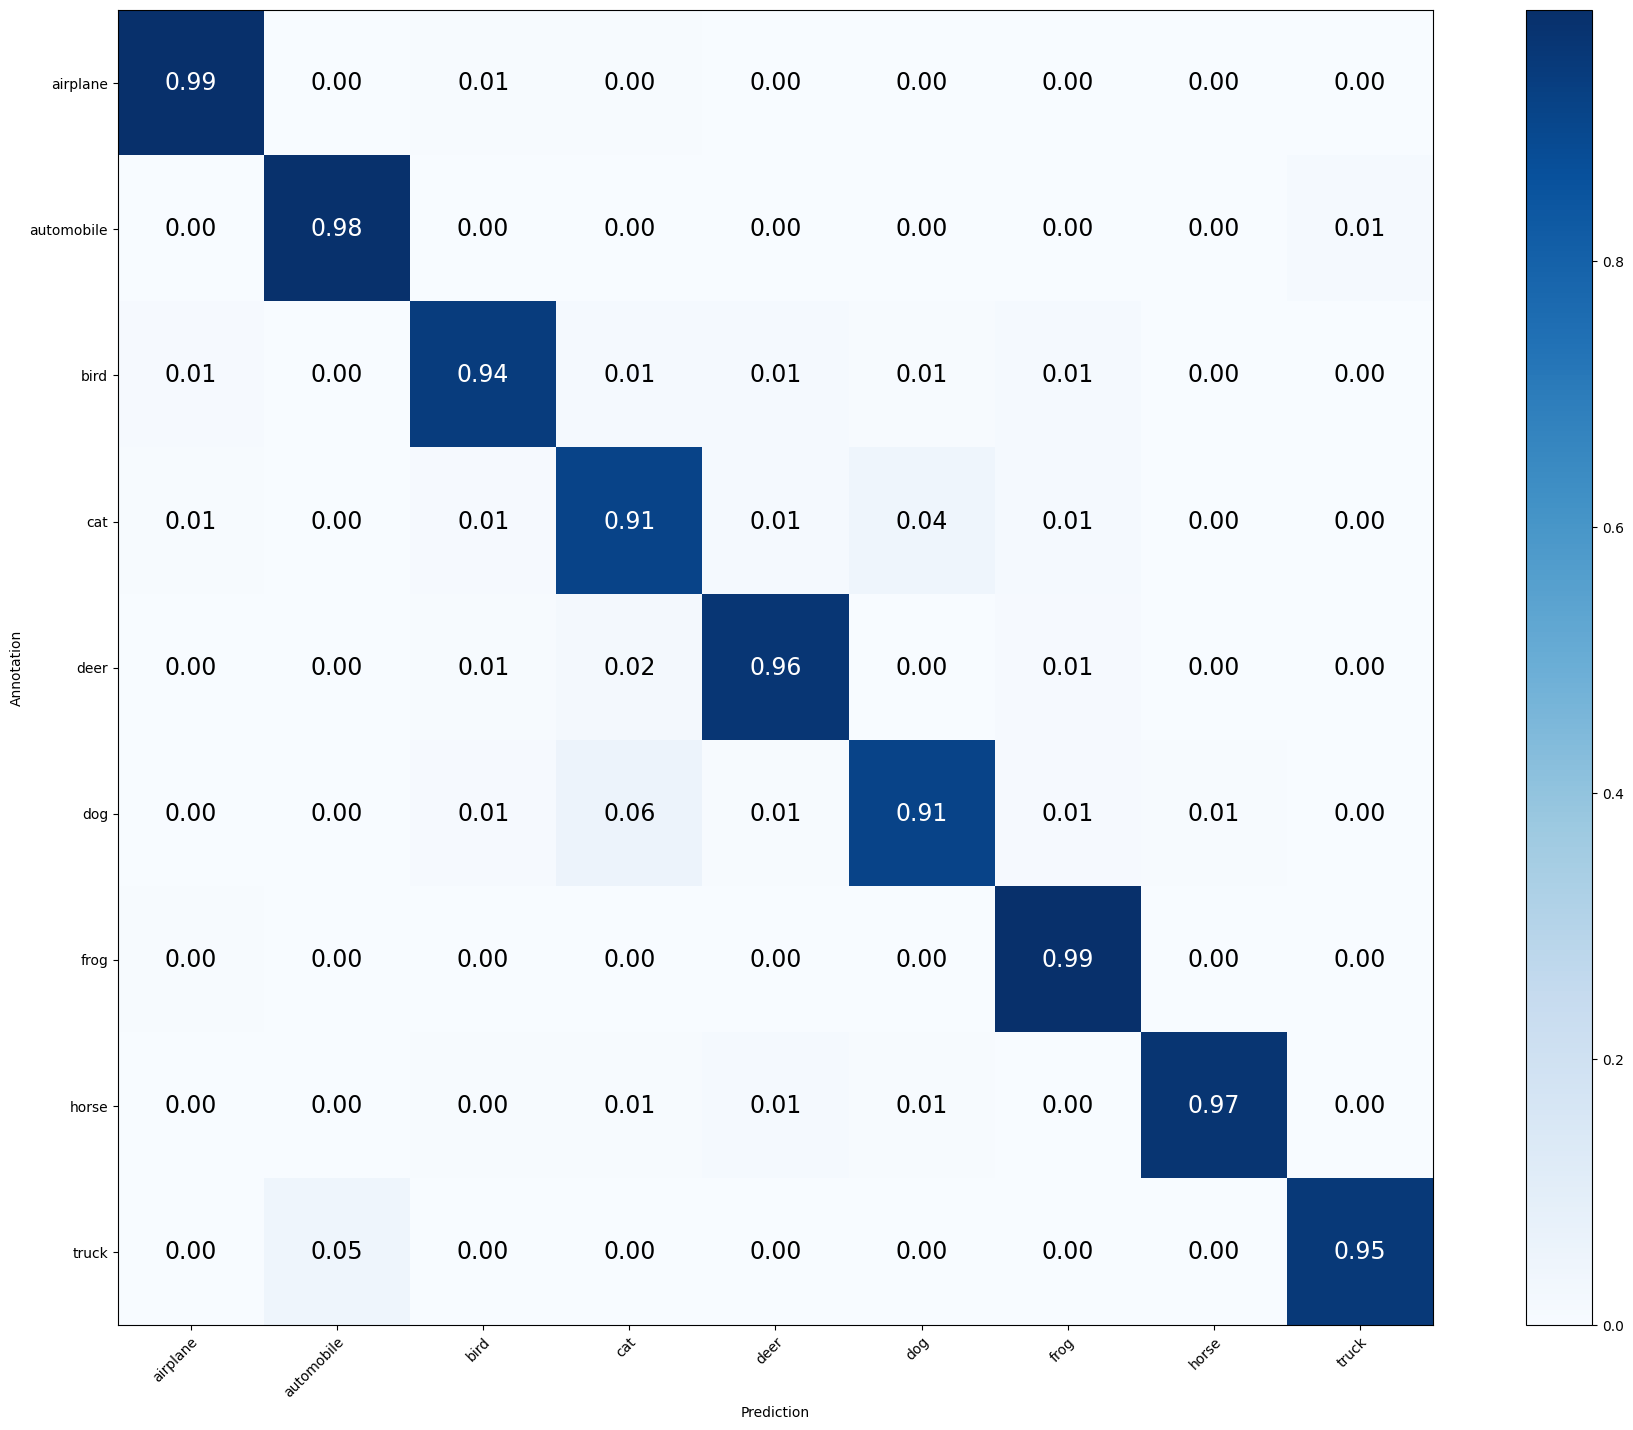

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

# Compute the confusion matrix
categories = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 9: 'ship', 9: 'truck'}
cm = confusion_matrix(y_true, y_pred, labels=list(categories.keys()))
draw_confusion_matrix(cm, categories)

In [ ]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 95.673%
Mean Recall: 95.677%
Mean Precision: 95.697%
> airplane: Recall: 98.676% Precision: 97.289% Specificity: 99.662% Dice: 97.978%
> automobile: Recall: 98.495% Precision: 95.247% Specificity: 99.385% Dice: 96.844%
> bird: Recall: 94.194% Precision: 96.414% Specificity: 99.561% Dice: 95.291%
> cat: Recall: 91.274% Precision: 90.367% Specificity: 98.783% Dice: 90.818%
> deer: Recall: 96.496% Precision: 95.257% Specificity: 99.398% Dice: 95.873%
> dog: Recall: 91.400% Precision: 93.648% Specificity: 99.222% Dice: 92.510%
> frog: Recall: 98.900% Precision: 95.741% Specificity: 99.448% Dice: 97.295%
> horse: Recall: 96.600% Precision: 98.773% Specificity: 99.849% Dice: 97.674%
> truck: Recall: 95.060% Precision: 98.537% Specificity: 99.824% Dice: 96.768%


# Comentarios

RESNET y DENSENET son arquitecturas de CNN cuyo objetivo es incrementar el rendimiento de la red neuronal aumentando el número de capas.
Sin embargo, esto supone un reto, ya que a partir de cierto punto, podemos empezar a perder accuracy debido al exceso de profundidad (vanishing gradient problem).
Ambos métodos solucionan el problema del vanishing gradient problem utilizando el método de skip connections.
ResNet agrega un atajo desde la función de entrada a la salida del mapeo que se puede aprender en cada bloque residual. Por lo que ResNet tendrá conexiones de omisión que omitirán algunas capas y permitirán que la capa actual de la red funcione al menos tan bien como las capas anteriores.
Por otra parte, dentro de un bloque denso, DenseNet va aún más allá al concatenar mapas de características en la salida de cada una de las siguientes capas.
DenseNet utiliza los mapas de características creados por todas las capas anteriores, lo que permite la reutilización de características, lo que conduce a una mejor representación de las mismas.

Por otra parte, en búsqueda de una solución más eficiente que pudiera ser ejecutada en dispositivos móbiles surge MobileNet y su predecesor MobileNetV2.
MobileNet gira en torno a la idea de utilizar convoluciones separables en profundidad, que consisten en una convolución en profundidad y una convolución puntual una tras otra.
MobileNet2 incorpora dos nuevas ideas: Inverted Residuals y Linear Bottlenecks layers.
Los Inverted Residuals reducen el requisito de memoria en comparación con el bloque residual clásico utilizando un enfoque narrow->wide->narrow en vez de un enfoque wide->narrow->wide.
Por otra parte, para poder mejorar el rendimiento del sistema tras aplicar los Inverted Residuals y no perder excesiva información, los autores introdujeron la idea de un cuello de botella lineal donde la última convolución de un bloque residual tiene una salida lineal antes de agregarse a las activaciones iniciales.

A la hora de comprobar el rendimiento de cada propuesta, en https://keras.io/api/applications/ se puede ver un desglose de las propuestas ejecutadas en este documento. En particular, destacar que DESNET es capaz de obetener mejores valores de accuracy, junto con una reducción en la memoria utilizada, así como en el número de parámetros empleados. Sin embargo, necesita de más tiempo de ejecución que su competidor.
Por otra parte, debido a la naturaleza de MOBILENET, consigue reducir drásticamente tanto el número de parámetros como la memoria utilizada. Sin embargo, a cambio, el accuracy es algo menor.


